# 测试 Better-Adapt 策略在 NBC 指标下对比 ADAPT 的表现

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print("yes!")
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2026-02-15 22:26:43.634984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


yes!


## 加载模型

### 1.分割数据集

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

设置时间 

In [5]:
from datetime import datetime
#from concurrent.futures import ThreadPoolExecutor # 多线程尝试
from tqdm import tqdm

# 设置时间  
set_hours=0
set_minutes=1
set_seconds=0

选择样本

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 超参数 选取的样本数量(至少2个)
N = 5
M = len(x_test)

In [7]:
# 挑选一些图片用于白盒测试
# indices = [800, 3433, 3496, 3592, 4322, 4395, 4706, 6101, 6223, 6715, 
#            7190, 7302, 7491, 7715, 8149, 8267, 8608, 9197, 9721, 9795]

# 随机取样
indices = random.sample(range(0, M + 1), N)
print(indices)

[8488, 7880, 2540, 4179, 4273]


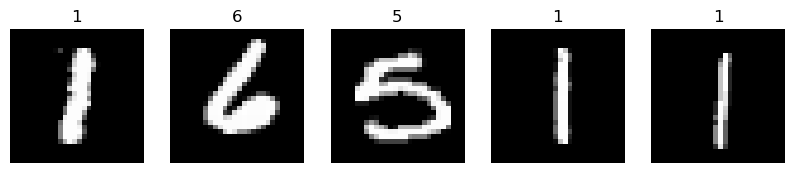

In [8]:
images = x_test[indices]
fig, ax = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for i, idx in enumerate(indices):
    ax[i].set_axis_off()
    ax[i].title.set_text(str(np.argmax(y_test[idx])))
    ax[i].imshow(np.reshape(images[i], (28, 28)), cmap='gray')
plt.show()

### 2. 导入模型

In [9]:
from model.model import LeNet5

model = LeNet5()
model.summary()

I0000 00:00:1771165608.629559   70295 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool1 (MaxPooling2D)     │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool1 (MaxPooling2D)     │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 120)            │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ before_softmax (Dense)          │ (None, 10)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ redictions (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,786 (421.04 KB)

 Trainable params: 107,786 (421.04 KB)

 Non-trainable params: 0 (0.00 B)

### 3. 训练

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_ = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=10, verbose=1)

Epoch 1/10


2026-02-15 22:26:51.187178: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c4224004dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-15 22:26:51.187223: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2026-02-15 22:26:51.221596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-15 22:26:51.437446: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90800
2026-02-15 22:26:51.475589: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-15 22:26:

 12/235 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1972 - loss: 2.2400

I0000 00:00:1771165616.276256   70411 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7371 - loss: 0.8796

2026-02-15 22:26:57.714481: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-15 22:26:57.714585: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-15 22:26:57.714648: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-15 22:26:57.714665: I external/l

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8837 - loss: 0.3998 - val_accuracy: 0.9712 - val_loss: 0.0950
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9723 - loss: 0.0894 - val_accuracy: 0.9810 - val_loss: 0.0554
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9811 - loss: 0.0613 - val_accuracy: 0.9831 - val_loss: 0.0537
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9849 - loss: 0.0485 - val_accuracy: 0.9868 - val_loss: 0.0384
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9877 - loss: 0.0398 - val_accuracy: 0.9842 - val_loss: 0.0523
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9894 - loss: 0.0339 - val_accuracy: 0.9897 - val_loss: 0.0304
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9911 - loss: 0.0285 - val_accuracy: 0.9881 - val_loss: 0.0346
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9920 - loss: 0.0259 - val_accuracy: 0.9897 - va

The final accuracy of the trained model is about 99%.

## 白盒测试

### 2. 创建测试策略

In [11]:
from adapt.network import Network
from adapt.fuzzer import WhiteBoxFuzzer

In [12]:
network = Network(model)

In [13]:
import importlib
import adapt.metric as me
importlib.reload(me)

<module 'adapt.metric' from '/mnt/e/_01Experimental_task/Graduation_Project/Better-ADAPT-main/adapt/metric/__init__.py'>

### 选择覆盖率指标

In [14]:
from adapt.metric import NeuronCoverage
from adapt.metric import NeuronBoundaryCoverage
from adapt.metric import StrongNeuronActivationCoverage
from adapt.metric import SignSignCoverage

NC = NeuronCoverage()
NBC = NeuronBoundaryCoverage()
SNAC = StrongNeuronActivationCoverage()
SSC = SignSignCoverage()

### 加载输入到测试工具

In [15]:
from adapt.strategy import BetterAdaptiveStrategy
from adapt.strategy import AdaptiveParameterizedStrategy

## NBC

In [16]:
fuzzers_better_nbc = []

In [17]:
for image in images:
    strategy = BetterAdaptiveStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, NBC, strategy)
    fuzzers_better_nbc.append(fuzzer)

In [18]:
archives_better_nbc = []
for i in tqdm(range(len(fuzzers_better_nbc)), desc='Better-ADAPT running...', unit='fuzzer'):  # 使用 tqdm 创建进度条
    fuzzer = fuzzers_better_nbc[i]
    result = fuzzer.start(hours=set_hours, minutes=set_minutes, seconds=set_seconds, append='min_dist')
    archives_better_nbc.append(result)
print('Done')

Better-ADAPT running...:   0%|          | 0/5 [00:00<?, ?fuzzer/s]/home/cx/miniconda3/envs/TFGPU/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e-04, tolerance: 1.006e-04
  model = cd_fast.enet_coordinate_descent(
Better-ADAPT running...:  20%|██        | 1/5 [01:00<04:03, 60.76s/fuzzer]/home/cx/miniconda3/envs/TFGPU/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.432e-06, tolerance: 2.570e-06
  model = cd_fast.enet_coordinate_descent(
/home/cx/miniconda3/envs/TFGPU/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWa

Done


In [23]:
fuzzers_adapt_nbc = []

In [24]:
for image in images:
    strategy = AdaptiveParameterizedStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, NBC, strategy)
    fuzzers_adapt_nbc.append(fuzzer)

In [25]:
archives_adapt_nbc = []
for i in tqdm(range(len(fuzzers_adapt_nbc)), desc='ADAPT running...', unit='fuzzer'):  # 使用 tqdm 创建进度条
    fuzzer = fuzzers_adapt_nbc[i]
    result = fuzzer.start(hours=set_hours, minutes=set_minutes, seconds=set_seconds, append='min_dist')
    archives_adapt_nbc.append(result)
print('Done')

ADAPT running...: 100%|██████████| 5/5 [05:00<00:00, 60.18s/fuzzer]

Done


### 4. 测试结果

In [26]:
def align_coverages(coverages, target_length=61):
    aligned_coverages = []
    for coverage in coverages:
        if len(coverage) > target_length:
            aligned_coverages.append(coverage[:target_length])  # 截断
        else:
            aligned_coverages.append(coverage + [coverage[-1]] * (target_length - len(coverage)))  # 填充
    return np.array(aligned_coverages)

In [27]:
# 这里代表横坐标的时间应与设置的时间相同（当然也可以自己调整）
set_time = set_hours*3600+set_minutes*60+set_seconds+1
times = list(range(set_time))

In [28]:
coverages_better = []
coverages = []
for archive in archives_better_nbc:
    current_t = 0
    coverage = []
    for t, cov in archive.timestamp:
        if t > current_t:
            coverage.append(cov)
            current_t += 1
    coverages.append(coverage)
coverages = align_coverages(coverages, set_time)
coverages = np.array(coverages, dtype=object)
coverages = np.mean(coverages, axis=0)
coverages_better.append(coverages)


In [29]:
coverages_adapt = []
coverages = []
for archive in archives_adapt_nbc:
    current_t = 0
    coverage = []
    for t, cov in archive.timestamp:
        if t > current_t:
            coverage.append(cov)
            current_t += 1
    coverages.append(coverage)
coverages = align_coverages(coverages, set_time)
coverages = np.array(coverages, dtype=object)
coverages = np.mean(coverages, axis=0)
coverages_adapt.append(coverages)


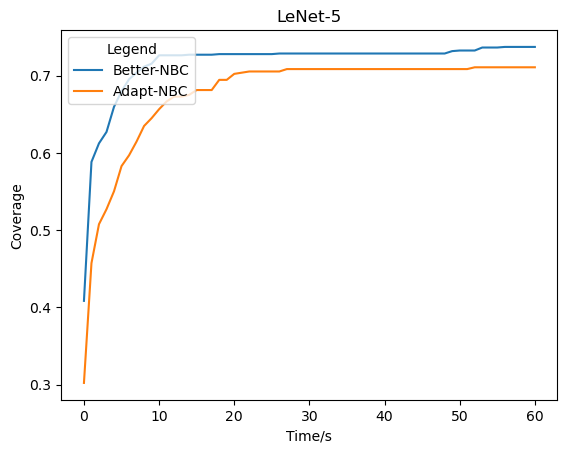

In [34]:

# 绘制 better 的折线图
plt.plot(coverages_better[0], linestyle='-', label=f'Better-NBC')
plt.plot(coverages_adapt[0], linestyle='-', label=f'Adapt-NBC')

# 添加图例、标题和坐标轴标签
plt.legend(title="Legend", loc="upper left", fontsize=10)  # 设置图例标题和位置
plt.title('LeNet-5')
plt.xlabel('Time/s')
plt.ylabel('Coverage')

# 显示图形
plt.show()

In [36]:
B = [[],[],[]]
total = 0
adversarial = 0
distance = 0
for archive in archives_better_nbc: # 具体到每个样本的测试输出
    total += archive.total
    adversarial += archive.adversarials
    d = 0.5 if archive.adversarials == 0 else np.mean(np.concatenate([archive.distance[label] for label in archive.distance.keys() if label != archive.label]))
    distance += d

B[0].append(total)
B[1].append(adversarial)
B[2].append(distance / len(archives_better_nbc))

In [37]:
print("Better-ADAPT output:")
print("totals:", B[0])
print("adversarials:", B[1])
print("A/T:", np.array(B[1])/np.array(B[0]))
print("distance:", B[2])

Better-ADAPT output:
totals: [4440]
adversarials: [48]
A/T: [0.01081081]
distance: [np.float32(0.33788916)]


### 选择打印样本的对应结果

Better-ADAPT: Metric is NBC
第0个输入样本


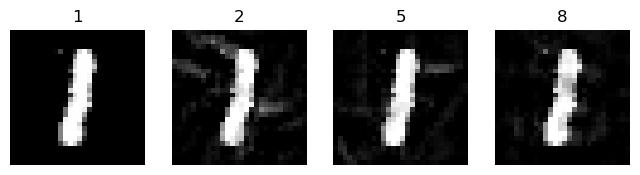

第1个输入样本


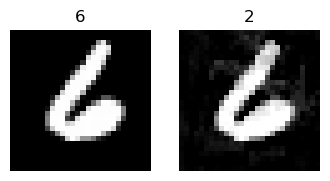

第2个输入样本


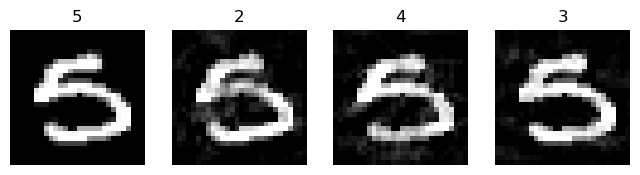

第3个输入样本


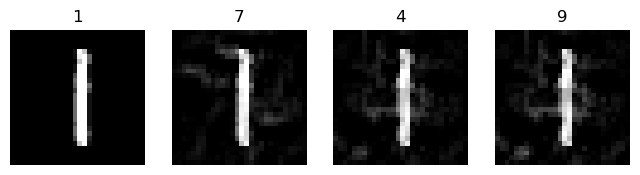

第4个输入样本


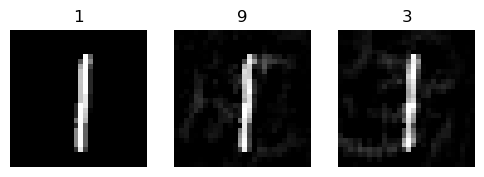

In [38]:
print(f'Better-ADAPT: Metric is NBC')
for index, archive in enumerate(archives_better_nbc):
    print(f"第{index}个输入样本")
    num_subplots = len(archive.found_labels)

    # 创建子图
    fig, ax = plt.subplots(1, num_subplots, figsize=(num_subplots * 2, 2))

    # 如果只有一个子图，将 ax 转换为列表
    if num_subplots == 1:
        ax = [ax]

    # 绘制每个子图
    for i, label in enumerate(archive.found_labels.keys()):
        ax[i].set_axis_off()  # 关闭坐标轴
        ax[i].set_title(str(label))  # 设置标题
        ax[i].imshow(
            np.reshape(archive.inputs[label][0], (28, 28)).clip(0, 1),
            cmap='gray'
        )

    plt.show()